# Original DRAEM Augmentation

In [ ]:
import torch
import math
import numpy as np

def lerp_np(x,y,w):
    fin_out = (y-x)*w + x
    return fin_out

def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise


def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2 * np.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1, 1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:, 1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:, :, 0], grid[:, :, 1] - 1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1] - 1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00 * (1 - t[:, :, 0]) + t[:, :, 0] * n10
    n1 = n01 * (1 - t[:, :, 0]) + t[:, :, 0] * n11
    return np.sqrt(2) * ((1 - t[:, :, 1]) * n0 + t[:, :, 1] * n1)


def rand_perlin_2d_np(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1

    angles = 2 * math.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.stack((np.cos(angles), np.sin(angles)), axis=-1)
    tt = np.repeat(np.repeat(gradients,d[0],axis=0),d[1],axis=1)

    tile_grads = lambda slice1, slice2: np.repeat(np.repeat(gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]],d[0],axis=0),d[1],axis=1)
    dot = lambda grad, shift: (
                np.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            axis=-1) * grad[:shape[0], :shape[1]]).sum(axis=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * lerp_np(lerp_np(n00, n10, t[..., 0]), lerp_np(n01, n11, t[..., 0]), t[..., 1])


def rand_perlin_2d(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])

    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim=-1) % 1
    angles = 2 * math.pi * torch.rand(res[0] + 1, res[1] + 1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)

    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0],0).repeat_interleave(d[1], 1)
    
    dot = lambda grad, shift: (
                torch.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            dim=-1) * grad[:shape[0], :shape[1]]).sum(dim=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0])

    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])


def rand_perlin_2d_octaves(shape, res, octaves=1, persistence=0.5):
    noise = torch.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * rand_perlin_2d(shape, (frequency * res[0], frequency * res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise

#Ours MOD dataset

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import cv2
import glob
import random
import matplotlib.pyplot as plt
import pickle

class MVTecDRAEMTrainDataset(Dataset):

    def __init__(self, root_dir, anomaly_source_path, resize_shape=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open('./Preprocessed_Data/IXI_jpg/train_dict.pkl', 'rb') as f:
            loaded_dict = pickle.load(f)

        self.root_dir = root_dir
        self.resize_shape=resize_shape
        self.image_paths_t1 = list(loaded_dict['t1'].values())
        self.image_paths_t2 = list(loaded_dict['t2'].values())
        self.mask_paths = list(loaded_dict['mask'].values())
        self.anomaly_source_paths = sorted(glob.glob(anomaly_source_path+"/bubbly/*.jpg"))

    def __len__(self):
        return len(self.image_paths_t1)

    def rescale(self, np_array):
        np_array = np.expand_dims(np_array, 0)
        np_array = (np_array * 2) - 1
        return np_array 
    
    def augment_image(self, image, gt_msk, anomaly_source_path):
        perlin_scale = 6
        min_perlin_scale = 0
        anomaly_source_img = cv2.imread(anomaly_source_path)
        anomaly_source_img = cv2.cvtColor(anomaly_source_img, cv2.COLOR_BGR2GRAY)
        anomaly_source_img = cv2.resize(anomaly_source_img, dsize=(self.resize_shape[1], self.resize_shape[0]))

        anomaly_img_augmented = anomaly_source_img
        perlin_scalex = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])
        perlin_scaley = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])

        perlin_noise = rand_perlin_2d_np((self.resize_shape[0], self.resize_shape[1]), (perlin_scalex, perlin_scaley))
        threshold = 0.5
        perlin_thr = np.where(perlin_noise > threshold, np.ones_like(perlin_noise), np.zeros_like(perlin_noise))
        
        filter_msk = gt_msk * perlin_thr / 255.0
        img_thr = anomaly_img_augmented.astype(np.float32) * filter_msk
        beta = torch.rand(1).numpy()[0] * 0.5
        augmented_image = image * (1 - filter_msk) + (1 - beta) * img_thr + beta * image * (filter_msk)
        
        no_anomaly = torch.rand(1).numpy()[0]
        if no_anomaly > 0.5:
            print("if case got hit")
            image = image.astype(np.float32)
            return image, np.zeros_like(perlin_thr, dtype=np.float32), np.array([0.0],dtype=np.float32) 
        else:
            print("else case got hit")
            augmented_image = augmented_image.astype(np.float32)
            has_anomaly = 1.0
            if np.sum(filter_msk) == 0:
                has_anomaly=0.0
            return augmented_image, filter_msk, np.array([has_anomaly],dtype=np.float32)

    def transform_image(self, image_path, gt_mask_path, anomaly_source_path):
        # read image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))

        # read gt mask
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        
        image = np.array(image  / 255.0).astype(np.float32)
        gt_mask = np.array(gt_mask / 255.0).astype(np.float32) 
        
        augmented_image, anomaly_mask, has_anomaly = self.augment_image(image, gt_mask, anomaly_source_path)
        
        return self.rescale(image), self.rescale(gt_mask), self.rescale(augmented_image), self.rescale(anomaly_mask), has_anomaly

    def __getitem__(self, idx):
        cls_choice = random.randint(0, 1)
        if cls_choice == 0:
            inp_img_path = self.image_paths_t1[idx]
        else:
            inp_img_path = self.image_paths_t2[idx]
            
        gt_mask_path = self.mask_paths[idx]
        anomaly_source_idx = torch.randint(0, len(self.anomaly_source_paths), (1,)).item()
        image, gt_mask, augmented_image, anomaly_mask, has_anomaly = self.transform_image(inp_img_path, gt_mask_path, self.anomaly_source_paths[anomaly_source_idx])

        sample = {'image': image, "gt_mask": gt_mask, "anomaly_mask": anomaly_mask, 'augmented_image': augmented_image, 'has_anomaly': has_anomaly, 'idx': idx}
        
        return torch.tensor(image), torch.tensor(gt_mask), torch.tensor(augmented_image), torch.tensor(anomaly_mask), torch.tensor(has_anomaly), torch.tensor(cls_choice)

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from prefetch_generator import BackgroundGenerator
from sklearn.metrics import roc_auc_score, average_precision_score
import sklearn

print("The scikit-learn version is {}.".format(sklearn.__version__))

dataset = MVTecDRAEMTrainDataset(
    root_dir="./Preprocessed_Data/IXI_jpg/",
    anomaly_source_path="./dtd/images/",
    resize_shape=[128, 128],
)

dataloader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=True)

def un_scale(img):
    img = (img + 1) / 2
    return img

anomaly_score_gt = []
anomaly_score_prediction = []

def show_images(inp_img, gt_mask, aug_img, aug_mask, save_name=""):
    # plt.figure
    fig, axs = plt.subplots(1, 4, figsize=(20, 15), dpi=150)

    # -------main image plot
    axs[0].imshow(inp_img[0], cmap="gray")
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    # -----mask images
    axs[1].imshow(gt_mask[0], cmap="gray")
    axs[1].set_title(f"GT Mask")
    axs[1].axis("off")

    # -----aug images
    axs[2].imshow(aug_img[0], cmap="gray")
    axs[2].set_title(f"aug image")
    axs[2].axis("off")
    
    # -----aug mask
    axs[3].imshow(aug_mask[0], cmap="gray")
    axs[3].set_title(f"aug maks")
    axs[3].axis("off")

    plt.tight_layout()
    # plt.savefig(f"./aug_plot/{save_name}.png")
    plt.show()
    
for idx_s, sample_batched in enumerate(dataloader):
    print(f"==>> len(dataloader): {len(dataloader)}")
    print(f"==>> str(idx_s): {str(idx_s)}")
    inp_image, inp_gt_mask, augm_image, ano_mask, has_ano, cls_val  = sample_batched
    
    inp_img = inp_image.squeeze(1).detach().cpu().numpy()
    gt_mask = inp_gt_mask.squeeze(1).detach().cpu().numpy()
    aug_inp_img = augm_image.squeeze(1).detach().cpu().numpy()
    aug_ano_mask = ano_mask.squeeze(1).detach().cpu().numpy()

    show_images(inp_img, gt_mask, aug_inp_img, aug_ano_mask, save_name=str(idx_s))
    break

In [1]:
import glob

image_paths_t1 = sorted(glob.glob("/home/lalith/Latent_SB/Preprocessed_Data/IXI_jpg/t1/*"))
image_paths_t2 = sorted(glob.glob("/home/lalith/Latent_SB/Preprocessed_Data/IXI_jpg/t2/*"))
mask_paths = sorted(glob.glob("/home/lalith/Latent_SB/Preprocessed_Data/IXI_jpg/mask/*"))

print(f"==>> image_paths_t1: {len(image_paths_t1)}")
print(f"==>> image_paths_t2: {len(image_paths_t2)}")
print(f"==>> mask_paths: {len(mask_paths)}")

==>> image_paths_t1: 80766
==>> image_paths_t2: 80215
==>> mask_paths: 80766


In [ ]:
train_dict = {}
t1_present = {}
t2_present = {}
mask_present = {}

for i in range(0, len(image_paths_t2)):
    t1_id = image_paths_t1[i].split('/')[-1].split('_')[0]  
    t2_id = image_paths_t2[i].split('/')[-1].split('_')[0]  
    mask_id = mask_paths[i].split('/')[-1].split('_')[0]
    if t2_id == mask_id:
        print(f"==>> image_paths_t2[i]: {image_paths_t2[i]}")
        print(f"==>> mask_paths[i]: {mask_paths[i]}")
        t2_present[image_paths_t2[i].split('/')[-1]] = image_paths_t2[i]
        mask_present[mask_paths[i].split('/')[-1]] = mask_paths[i]
    
    if t1_id == t2_id and t1_id == mask_id:
        print(f"==>> image_paths_t1[i]: {image_paths_t1[i]}")
        t1_present[image_paths_t1[i].split('/')[-1]] = image_paths_t1[i]
        
train_dict['t1'] = t1_present
train_dict['t2'] = t2_present
train_dict['mask'] = mask_present

In [ ]:
import pickle 

with open('/home/lalith/Latent_SB/Preprocessed_Data/train_dict.pkl', 'wb') as f:
    pickle.dump(train_dict, f)

In [ ]:
with open('/home/lalith/Latent_SB/Preprocessed_Data/train_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [35]:
from Latent_SB.autoencoder.autoencoder import Autoencoder, Encoder, Decoder, DiagonalGaussianDistribution
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [36]:
def autoencoder_net():
    encoder = Encoder(
        channels=128,
        channel_multipliers=[1, 2, 4],
        n_resnet_blocks=2,
        in_channels=3,
        z_channels=3,
    )
    decoder = Decoder(
        channels=128,
        channel_multipliers=[1, 2, 4],
        n_resnet_blocks=2,
        out_channels=3,
        z_channels=3,
    )

    return encoder.cuda(), decoder.cuda()

In [42]:
enc, dec = autoencoder_net()
ae_net = Autoencoder(encoder=enc, decoder=dec, z_channels=3, emb_channels=3)

ae_net.init_from_ckpt(path="/home/lalith/Latent_SB/autoencoder/results/ae/latest.pt",)
first_stage_model = ae_net.eval()
# self.first_stage_model.train = False  # type: ignore
for param in first_stage_model.parameters():
    param.requires_grad = False

first_stage_model = first_stage_model.cuda()
scale_factor = 1.0

@torch.no_grad()
def decode_first_stage(z):
    z = 1.0 / scale_factor * z
    return first_stage_model.decode(z)

@torch.no_grad()
def encode_first_stage(x):
    return first_stage_model.encode(x)

def get_first_stage_encoding(encoder_posterior):
    if isinstance(encoder_posterior, DiagonalGaussianDistribution):
        z = encoder_posterior.sample()
    elif isinstance(encoder_posterior, torch.Tensor):
        z = encoder_posterior
    else:
        raise NotImplementedError(
            f"encoder_posterior of type '{type(encoder_posterior)}' not yet implemented"
        )
    return scale_factor * z


==>> loading autoencoder weights from path: /home/lalith/Latent_SB/autoencoder/results/ae/latest.pt
==>> loaded autoencoder weights complete


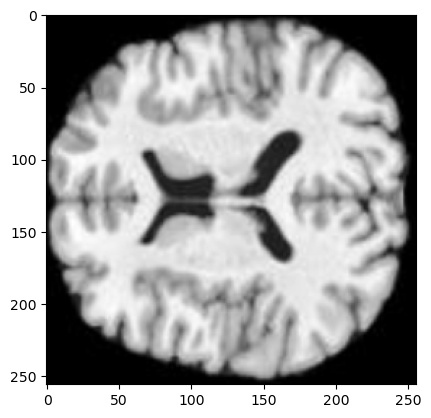

In [56]:
def rescale(np_array):
    np_array = np.expand_dims(np_array, 0)
    np_array = (np_array * 2) - 1
    return np_array 
    
image = cv2.imread(list(t1_present.values())[4000], cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, dsize=(256, 256))

# read gt mask
gt_mask = cv2.imread(list(mask_present.values())[4000], cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, dsize=(256, 256))

image = np.array(image  / 255.0).astype(np.float32)
gt_mask = np.array(gt_mask / 255.0).astype(np.float32) 

image = rescale(image)
gt_mask = rescale(gt_mask)

image = torch.tensor(image)
gt_mask = torch.tensor(gt_mask)

image = torch.cat((image,image,image), dim=0)
gt_mask = torch.cat((gt_mask,gt_mask,gt_mask), dim=0)

plt.imshow(image[1].detach().cpu().numpy(), cmap="gray")

==>> enc_img.shape: torch.Size([1, 3, 64, 64])


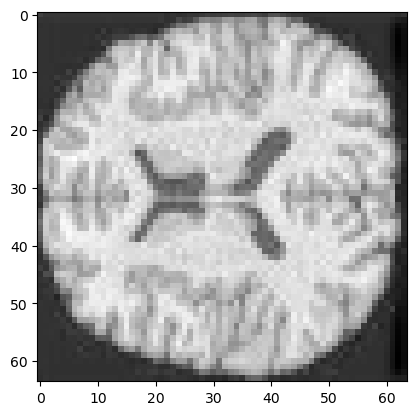

In [ ]:
enc_posterior = encode_first_stage(image.unsqueeze(0).cuda())
enc_img = get_first_stage_encoding(enc_posterior)
print(f"==>> enc_img.shape: {enc_img.shape}")
plt.imshow(enc_img[0][1].detach().cpu().numpy(), cmap="gray")

==>> enc_img.shape: torch.Size([1, 3, 256, 256])


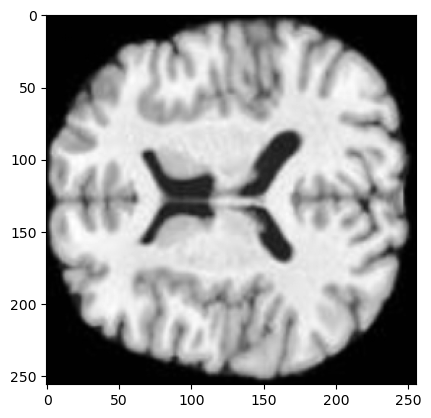

In [54]:
pred_dec = decode_first_stage(enc_img)
print(f"==>> enc_img.shape: {pred_dec.shape}")
plt.imshow(pred_dec[0][1].detach().cpu().numpy(), cmap="gray")